In [ ]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185319 sha256=b1c12090261f868e3283a12e9ee430cd0da4b44f94235f5c1a2396063802ef38
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [1]:
%%writefile parallel_spectrogram.py
import numpy as np
from mpi4py import MPI
import sys
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

nwindowsteps, window_width = 1000, 2*2*np.pi
if len(sys.argv) == 3:
    nwindowsteps = int(sys.argv[1])
    window_width=float( sys.argv[2] )*2*np.pi

# generate the signal
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y+=np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
y+=np.sin(5.5*t)*np.exp(-(t-10*2*np.pi)**2/2/5**2)
y+=np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/2/5**2)

w=np.fft.fftfreq(len(y), d=(t[1]-t[0])/2/np.pi)

time_start = -20*2*np.pi
time_end = 20*2*np.pi

t_window = np.linspace(time_start, time_end, nwindowsteps)
t_window = np.array_split(t_window, size)[rank]

spectrogram_part=np.empty([len(t), len(t_window)])

for n,t_w in enumerate(t_window):  
    window_position=t_w
    window_function=np.exp(-(t-window_position)**2/2/window_width**2)
    y_window=y*window_function
    sp = np.fft.fft(y_window)
    spectrogram_part[:,n]=abs(sp)

spectrogram_total = comm.gather(spectrogram_part, root=0)
if rank == 0:
    spectrogram_total = np.concatenate(spectrogram_total, axis = 1)

#save the spectrogram

# if rank == 0:
#   plt.figure(figsize=(10,8))
#   plt.imshow(spectrogram_total, aspect='auto', origin='lower', extent=[min(t)/2/np.pi, max(t)/2/np.pi,w[0], 2*w[int(len(w)/2)-1]])
#   plt.colorbar()
#   plt.ylim(0,10)
#   plt.xticks(fontsize = 20)
#   plt.yticks(fontsize = 20)
#   plt.xlabel('Time, cycles',fontsize = 20)
#   plt.ylabel('Frequency',fontsize = 20)
#   plt.title('Spectrogram, color corresponds to power spectrum \n',fontsize = 20)
#   plt.savefig("spectrogram.png")

Writing parallel_spectrogram.py


In [ ]:
!mpirun -n 3 --allow-run-as-root python parallel_spectrogram.py 1000 2

In [2]:
import time

In [3]:
T = []
for i in range(1,11):
    t_start = time.time()
    !mpirun -n {i} python parallel_spectrogram.py 1000 2
    t_end = time.time()
    T.append(t_end-t_start)
    print('Time: {:6.3f}     Processes: {}'.format(T[-1],i))

Time:  5.541     Processes: 1
Time:  2.946     Processes: 2
Time:  4.047     Processes: 3
Time:  6.244     Processes: 4
Time:  6.296     Processes: 5
Time:  9.500     Processes: 6
Time:  7.787     Processes: 7
Time: 10.644     Processes: 8
Time: 12.990     Processes: 9
Time: 13.134     Processes: 10


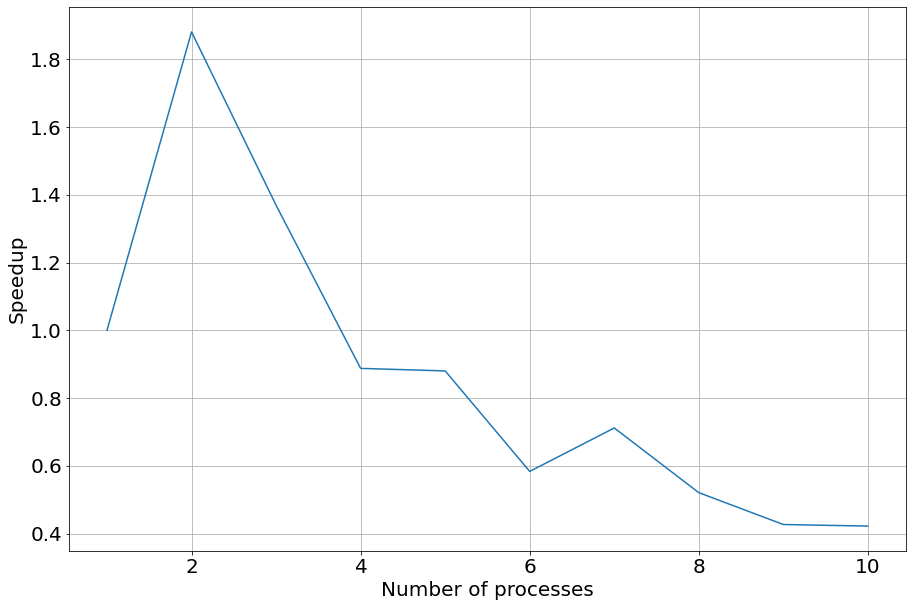

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(range(1,11), [T[0]/i for i in T])
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Speedup', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid();